<a href="https://colab.research.google.com/github/0x1beef/uap/blob/main/src/gimbal_object_data.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a href="https://kaggle.com/kernels/welcome?src=https://github.com/0x1beef/uap/blob/main/src/gimbal_object_data.ipynb">
    <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"   />
</a>

In [1]:
url = 'https://raw.githubusercontent.com/0x1beef/uap/main/src'
import urllib.request
for py_file in ['utils.py','common.py']:
    urllib.request.urlretrieve(f'{url}/{py_file}', py_file)
import utils, common

## **Get the frames**

In [2]:
gimbal = common.gimbal_from_huggingface()

gimbal/2 - GIMBAL.wmv:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

ffmpeg -hide_banner -loglevel error -i "gimbal/2 - GIMBAL.wmv" -vf "format=gray, crop=428:428:104:27:exact=1" -vsync vfr -start_number 0 gimbal/frame_%04d.png
'gimbal': 1031 frames @ 29.97 fps


## **Match the last WH frame to the first BH frame**

In [3]:
import matplotlib.pyplot as plt
def show(*imgs):
    for img in imgs:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.show()

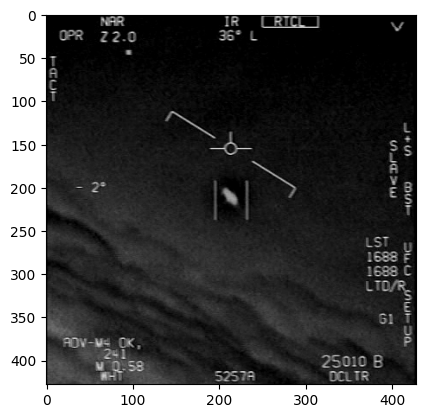

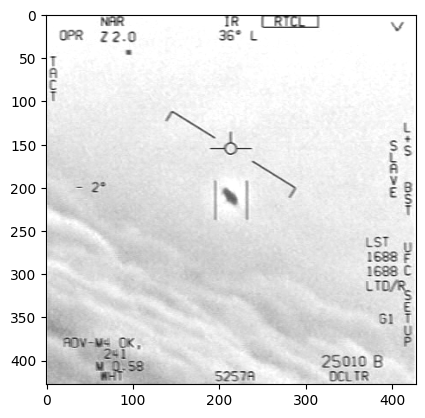

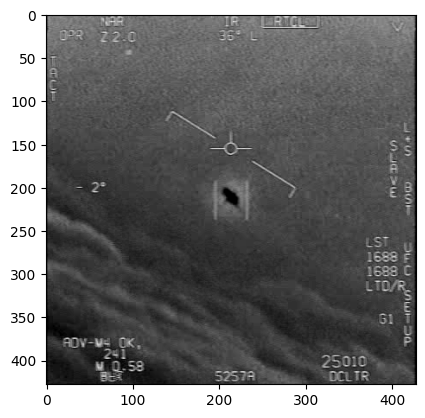

In [4]:
white_hot = gimbal.get_frame(370)
black_hot = gimbal.get_frame(372)
inv_wh = ~white_hot
show(white_hot, inv_wh, black_hot)

def is_black_hot(frame):
    return frame >= 372

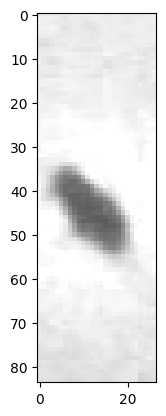

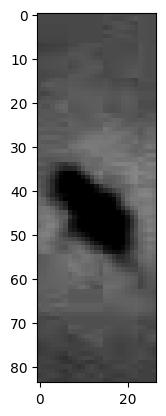

(g,a,b) = (4.041, 0.434, -2.670)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   1   1   1   1   1   1   2   2   2   2   2   2   3   3   3
   3   3   4   4   4   4   5   5   5   5   6   6   6   6   7   7   7   8
   8   8   8   9   9   9  10  10  10  11  11  12  12  12  13  13  14  14
  15  15  15  16  16  17  17  18  18  19  19  20  20  21  22  22  23  23
  24  25  25  26  26  27  28  28  29  30  30  31  32  33  33  34  35  36
  37  37  38  39  40  41  42  43  44  44  45  46  47  48  49  50  51  52
  53  54  56  57  58  59  60  61  62  64  65  66  67  68  70  71  72  74
  75  76  78  79  

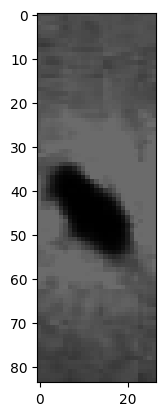

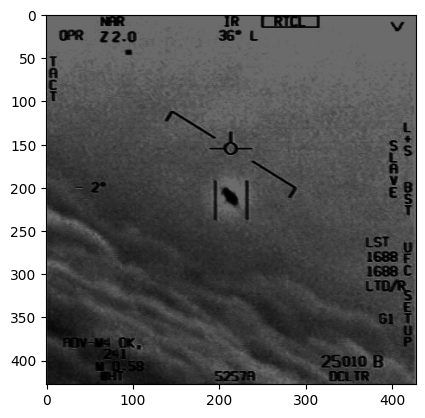

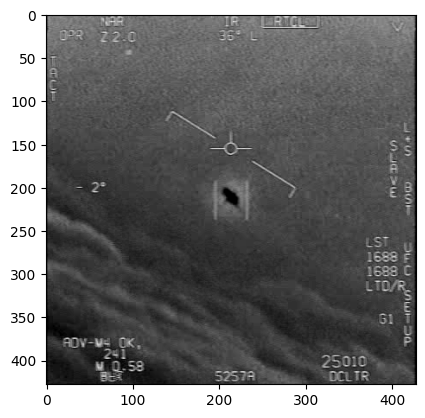

In [5]:
import numpy as np
from scipy.optimize import curve_fit

def get_wh_to_bh_lookup():
    rows = slice(166,250); cols = slice(201, 228)
    inv_wh_roi = inv_wh[rows, cols]
    bh_roi = black_hot[rows, cols]
    show(inv_wh_roi, bh_roi)

    xdata = inv_wh_roi.ravel()
    ydata = bh_roi.ravel()
    def func(x, g, a, b):
        return a * np.power(x / 255, g) * 255 + b
    popt, pcov = curve_fit(func, xdata, ydata)
    (g,a,b) = popt
    print(f'(g,a,b) = ({g:.3f}, {a:.3f}, {b:.3f})')

    def func_gab(x):
        return func(x, g, a, b)
    gab_lookup = np.array([np.clip(func_gab(x),0,255) for x in range(0,256)], np.uint8)
    print(gab_lookup)

    show(np.take(gab_lookup, inv_wh_roi))
    show(np.take(gab_lookup, inv_wh))
    show(black_hot)
    #show(abs(func_gab(inv_wh)-black_hot))
    return gab_lookup

gab_lookup = get_wh_to_bh_lookup()
def make_black_hot(img):
    return np.take(gab_lookup, ~img)

## **Calculate the geometry**

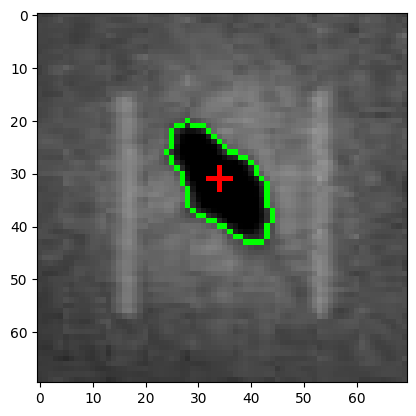

GeometryData(glare_angle=50.243511433872655, center_of_mass=(213.30842911877394, 210.90676883780333))


In [6]:
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass
import cv2

class Roi:
    def __init__(self, full_img_shape):
        (h, w) = full_img_shape
        roi_factor = 12
        (ofsy, ofsx) = (int(h / roi_factor), int(w / roi_factor))
        (midy, midx) = (int(h / 2), int(w / 2))
        self.y0 = midy - ofsy; self.y1 = midy + ofsy
        self.x0 = midx - ofsx; self.x1 = midx + ofsx
    def get(self, img):
        return img[self.y0:self.y1, self.x0:self.x1]
    
def point_from_roi(point, roi):
    return (point[0] + roi.y0, point[1] + roi.x0)
def point_to_roi(point, roi):
    return (point[0] - roi.y0, point[1] - roi.x0)

def get_frame_roi(frame):
    img = gimbal.get_frame(frame)
    roi = Roi(img.shape)
    roi_img = roi.get(img)
    return (roi, roi_img)

def get_binary_img(img, factor):
    (thresh, binary_img) = cv2.threshold(img, 255 * factor, 255, cv2.THRESH_BINARY)
    return binary_img

def get_contour(binary_img):
    (contours, img) = cv2.findContours(binary_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    (h, w) = binary_img.shape
    area_threshold = h * w * 0.7
    def area_key(contour):
        area = cv2.contourArea(contour)
        return area if area < area_threshold else 0
    contour = max(contours, key=area_key)
    return contour

@dataclass
class GeometryData:
    glare_angle: float # degrees
    center_of_mass: (float, float) # (x,y)
    def to_dict(self):
        return {
            'glare_angle': self.glare_angle,
            'center_of_mass_x': self.center_of_mass[0],
            'center_of_mass_y': self.center_of_mass[1],
        }

def get_contour_geometry(contour, roi):
    m = cv2.moments(contour)
    elongation_angle = math.atan2(2 * m['mu11'], m['mu20'] - m['mu02']) / 2
    center_of_mass = (m['m10'] / m['m00'], m['m01'] / m['m00'])
    return GeometryData(math.degrees(elongation_angle), point_from_roi(center_of_mass, roi))

def show_geometry(geom, roi, roi_img, contour):
    roi_rgb = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2RGB)
    roi_rgb = cv2.drawContours(roi_rgb, [contour], -1, (0,255,0), 1)
    (x, y) = geom.center_of_mass; (x, y) = (int(x), int(y))
    roi_rgb = cv2.drawMarker(roi_rgb, point_to_roi((x,y), roi), (255,0,0), cv2.MARKER_CROSS, 5)
    plt.imshow(roi_rgb)
    plt.show()
    
def get_geometry(frame, show_geom = False):
    (roi, roi_img) = get_frame_roi(frame)
    if not is_black_hot(frame):
        roi_img = make_black_hot(roi_img)
    binary_img = get_binary_img(roi_img, 0.2)
    contour = get_contour(binary_img)
    geom = get_contour_geometry(contour, roi)
    if show_geom == True:
        show_geometry(geom, roi, roi_img, contour)
    return geom

def test_geometry():
    frame = 433
    geom = get_geometry(frame, show_geom = True)
    print(geom)
    
test_geometry()

,glare_angle,center_of_mass_x,center_of_mass_y
0,44.754770,211.832026,211.280392
1,44.774282,212.162427,210.585127
2,47.272436,212.630073,210.392548
3,48.072223,212.554429,210.332657
4,47.135192,212.736027,210.622222
...,...,...,...
1026,-63.289478,212.729350,210.701230
1027,-65.073287,212.761494,210.820690
1028,-65.246652,212.935252,210.872302
1029,-65.409900,213.052788,211.066429


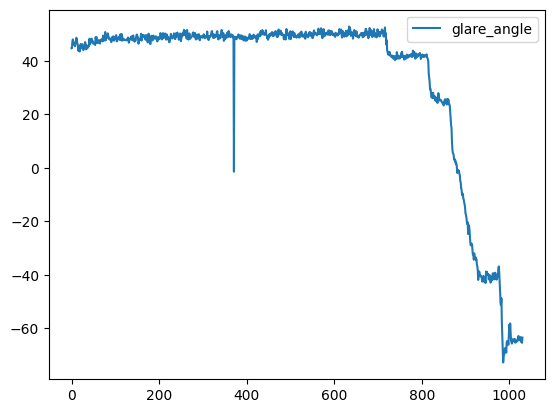

In [7]:
import pandas as pd
df_geom = pd.DataFrame.from_records(
    [get_geometry(frame).to_dict() for frame in range(0, gimbal.get_frame_count())]
)
df_geom.glare_angle.plot(legend = True)
df_geom

## **Get the calculated horizon values from Sitrec**

In [8]:
!git clone --depth 1 https://github.com/MickWest/sitrec.git
!cd sitrec && cp config.js.example config.js

Cloning into 'sitrec'...
remote: Enumerating objects: 1155, done.
remote: Counting objects: 100% (1155/1155), done.
remote: Compressing objects: 100% (1042/1042), done.
remote: Total 1155 (delta 92), reused 913 (delta 81), pack-reused 0
Receiving objects: 100% (1155/1155), 78.14 MiB | 32.38 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [9]:
!curl -fsSL https://bun.sh/install | bash

import os
os.environ['PATH'] = "~/.bun/bin:" + os.environ['PATH']

######################################################################## 100.0%
bun was installed successfully to ~/.bun/bin/bun 

Added "~/.bun/bin" to $PATH in "~/.bashrc" 

To get started, run: 

  source /root/.bashrc 
  bun --help 


In [10]:
!cd sitrec && bun install

bun install v1.1.12 (43f0913c)
[7.20ms] migrated lockfile from package-lock.json
  📦 Installing [111/317]   📦 Installing [116/317]   📦 Installing [127/317]   📦 Installing [146/317]   📦 Installing [166/317]   📦 Installing [189/317]   📦 Installing [214/317]   📦 Installing [233/317]   📦 Installing [262/317]   📦 Installing [266/317]   📦 Installing [284/317]   📦 Installing [285/317]   📦 Installing [286/317]   📦 Installing [297/317]   📦 Installing [308/317]   🔒 Saving lockfile... 
+ acorn@8.11.3
+ astronomy-engine@2.1.19
+ axios@1.6.8
+ babel-loader@8.3.0
+ buffer@6.0.3
+ copy-webpack-plugin@10.2.4
+ css-loader@6.10.0
+ escodegen@2.1.0
+ estraverse@5.3.0
+ html-webpack-plugin@5.6.0
+ jquery@3.7.1
+ json-stringify-pretty-compact@4.0.0
+ mathjs@12.4.1
+ mini-css-extract-plugin@2.8.1
+ ndarray@1.0.19
+ ndarray-pack@1.2.1
+ omggif@1.0.10
+ ppm@0.0.0
+ satellite.js@5.0.0
+ seedrandom@3.0.5
+ stream@0.0.2
+ style-loader@3.3.4
+ terser-webpack-plugin@5.3.10
+ three-text2d@0.6.0
+ ts-loader@9.5.1
+ 

In [11]:
%%writefile horizon.js
// note: the Sitrec internal API may change over time
import { initSitch } from "./sitrec/src/indexCommon.js"
import { get_real_horizon_angle_for_frame } from "./sitrec/src/JetStuff.js"
import { Sit } from "./sitrec/src/Globals.js"
import csv from "./sitrec/src/js/jquery.csv.js"
import fs from "node:fs"

await initSitch("gimbal", "SitGimbal.js")

var horizon_column = [["human_horizon"]]
for(let frame = 0; frame < Sit.frames; frame++) {
    const horizon = get_real_horizon_angle_for_frame(frame);
    horizon_column.push([horizon])
}

const csv_text = csv.fromArrays(horizon_column)
fs.writeFileSync("sitrec_data.csv", csv_text)

Writing horizon.js


In [12]:
!bun horizon.js

Running as a console application
SITREC_ROOT = ./sitrec/
SITREC_SERVER = http://localhost/sitrec/sitrecServer/
REQUIRING _configParams in config.js
Instantiating CNodeManager
CUnits: changeUnits: nautical
Found Sitch: SitGimbal.js Sitch Object Name = SitGimbal
Found Sitch: SitGimbal.js Sitch Object Name = SitGimbalNear
Setting units to:  Nautical
CUnits: changeUnits: Nautical
++++++++++++++++++++ Loading assets
++++ Loading asset  FA18Model  from  models/FA-18F.glb
>>> loadAsset() Loading Started: ./sitrec/data/models/FA-18F.glb GlobPars=NaN id=FA18Model
<<< loadAsset() Loading Finished: ./sitrec/data/models/FA-18F.glb id=FA18Model
parseAsset(./sitrec/data/models/FA-18F.glb,FA18Model,<buffer>)
parseAsset: DONE Parse ./sitrec/data/models/FA-18F.glb
<<< loadAsset() parsing Finished: ./sitrec/data/models/FA-18F.glb GlobPars=NaN id=FA18Model
++++ Loading asset  GimbalCSV  from  gimbal/GimbalData.csv
>>> loadAsset() Loading Started: ./sitrec/data/gimbal/GimbalData.csv GlobPars=NaN id=Gimbal

In [13]:
import pandas as pd
df_sitrec = pd.read_csv("sitrec_data.csv")
df_sitrec

,human_horizon
0,-16.623859
1,-16.628619
2,-16.633649
3,-16.703466
4,-16.709074
...,...
1026,-29.707314
1027,-29.602813
1028,-29.599255
1029,-29.596001


## **Collect all the data and upload it to Hugging Face**

In [14]:
df = df_geom.join(df_sitrec)
df

,glare_angle,center_of_mass_x,center_of_mass_y,human_horizon
0,44.754770,211.832026,211.280392,-16.623859
1,44.774282,212.162427,210.585127,-16.628619
2,47.272436,212.630073,210.392548,-16.633649
3,48.072223,212.554429,210.332657,-16.703466
4,47.135192,212.736027,210.622222,-16.709074
...,...,...,...,...
1026,-63.289478,212.729350,210.701230,-29.707314
1027,-65.073287,212.761494,210.820690,-29.602813
1028,-65.246652,212.935252,210.872302,-29.599255
1029,-65.409900,213.052788,211.066429,-29.596001


In [15]:
metadata = {
    'wh_to_bh_lookup' : gab_lookup.tolist(),
    'fps': gimbal.fps
}
utils.to_parquet_ext(df, 'object_data.parquet', 'gimbal', metadata)

In [16]:
utils.upload_to_huggingface('object_data.parquet', 'logicbear/gimbal/data')